# <center> Model training with data augmentation </center>

## Importing libraires

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import math
import seaborn as sns
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import glob

print('Libraries imported!')

Libraries imported!


## Emptying image folders

In [2]:
folders = ['../confusion_matrix_data_augmentation/FN/*.png',
           '../confusion_matrix_data_augmentation/FP/*.png',
           '../confusion_matrix_data_augmentation/TN/*.png',
           '../confusion_matrix_data_augmentation/TP/*.png']

for i in range(len(folders)):
    files = glob.glob(folders[i])
    for f in files:
        os.remove(f)

## Changing computation locations on the GPU if available <br>

additional information: https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

True
1
Using cuda device


## Defining a custom Dataset class

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file, header=None)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + ".png") 
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

## Defining transformation

In [5]:
transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.22)) ])

transform_train = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(360),
                    transforms.CenterCrop(90),
                    #transforms.RandomRotation(90),
                    #transforms.RandomCrop(size = 90, padding = 25),
                    #transforms.ColorJitter(brightness=.5, hue=.5),
                    #transforms.RandomAutocontrast(p=0.5),
                    transforms.ToTensor(), 
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.22)) ])

## Initializing objects

In [6]:
batch_size = 6

trainset = CustomImageDataset("../tables/train_rotation.csv", 
                              "../data/train_rotation", 
                              transform=transform_train)

testset = CustomImageDataset("../tables/test.csv", 
                             "../data/test", 
                             transform=transform)

validationset = CustomImageDataset("../tables/validation.csv", 
                                   "../data/validation", 
                                   transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,    
                                         shuffle=False, num_workers=0)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, 
                                               shuffle=False, num_workers=0)

classes = ('no palm', 'palm')

In [7]:
train_batches_nb = math.ceil(len(trainset) / batch_size)
print(f'The number of training elements is {len(trainset)} and the number of batches is {train_batches_nb}.')

validation_batches_nb = math.ceil(len(validationset) / batch_size)
print(f'The number of validation elements is {len(validationset)} and the number of batches is {validation_batches_nb}.')

The number of training elements is 3104 and the number of batches is 518.
The number of validation elements is 3142 and the number of batches is 524.


If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0. <br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## Defining the model

In [8]:
net = models.resnet18(pretrained=True) 
net.fc = torch.nn.Linear(512, 2) 

net.to(device)
print('Model placed on {} device'.format(device))

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.0012, momentum=0.9, weight_decay = 0.008) 

Model placed on cuda device


For more information on regularization: https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch

In [9]:
#net.eval()

## Learning rate scheduling

In [10]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)

## Learning rate computation

In [11]:
epochs = 300
lrs = []

for i in range(epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    print("Epoch = ", i," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],5))
    scheduler.step()

Epoch =  0  , Learning Rate =  0.0012
Epoch =  1  , Learning Rate =  0.0012
Epoch =  2  , Learning Rate =  0.0012
Epoch =  3  , Learning Rate =  0.0012
Epoch =  4  , Learning Rate =  0.0012
Epoch =  5  , Learning Rate =  0.0012
Epoch =  6  , Learning Rate =  0.0012
Epoch =  7  , Learning Rate =  0.0012
Epoch =  8  , Learning Rate =  0.0012
Epoch =  9  , Learning Rate =  0.0012
Epoch =  10  , Learning Rate =  0.0012
Epoch =  11  , Learning Rate =  0.0012
Epoch =  12  , Learning Rate =  0.0012
Epoch =  13  , Learning Rate =  0.0012
Epoch =  14  , Learning Rate =  0.0012
Epoch =  15  , Learning Rate =  0.0012
Epoch =  16  , Learning Rate =  0.0012
Epoch =  17  , Learning Rate =  0.0012
Epoch =  18  , Learning Rate =  0.0012
Epoch =  19  , Learning Rate =  0.0012
Epoch =  20  , Learning Rate =  0.0012
Epoch =  21  , Learning Rate =  0.0012
Epoch =  22  , Learning Rate =  0.0012
Epoch =  23  , Learning Rate =  0.0012
Epoch =  24  , Learning Rate =  0.0012
Epoch =  25  , Learning Rate =  0.0

## Displaying learning rate across epochs

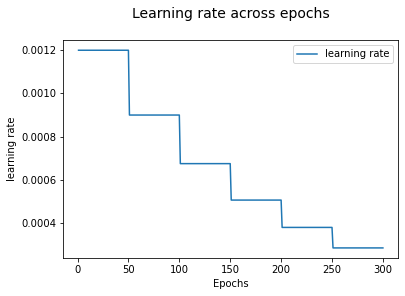

In [12]:
fig, ax = plt.subplots()
ax.plot(range(1,epochs+1), lrs, label = 'learning rate')
ax.set_title('Learning rate across epochs\n', fontsize=14)
ax.set_xlabel('Epochs')
ax.set_ylabel('learning rate')
ax.legend()
plt.show()

## Training the model

In [13]:
correct = 0
total = 0
accuracy = []

running_loss_per_epoch_list = []
validation_loss_per_epoch_list = []

for epoch in range(epochs):

    running_loss_per_epoch = 0.0
    for i, data in enumerate(trainloader, 0): 
        inputs, labels = data 
        inputs, labels = inputs.to(device), labels.to(device) 

        optimizer.zero_grad() 

        outputs = net(inputs) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step() 
        
        loss = loss.cpu()
        running_loss_per_epoch += loss.item()

        if i == train_batches_nb -1:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss_per_epoch / len(trainset)))
            running_loss_per_epoch_list.append(running_loss_per_epoch/len(trainset))
            running_loss_per_epoch = 0.0

    with torch.no_grad():
        validation_loss_per_epoch = 0.0
        
        for i, data in enumerate(validationloader): 
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            probability, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss = loss.cpu()
            validation_loss_per_epoch += loss.item()
            
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

            if i == validation_batches_nb -1:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, validation_loss_per_epoch / len(validationset)))
                validation_loss_per_epoch_list.append(validation_loss_per_epoch/len(validationset))
                validation_loss_per_epoch = 0.0
                accuracy.append(100 * correct / total)
                print('Accuracy : %.2f %%' % (100 * correct / total))
                
    scheduler.step()
                      
print('Finished Training')

[1,   518] loss: 0.044
[1,   524] loss: 0.192
Accuracy : 52.71 %
[2,   518] loss: 0.026
[2,   524] loss: 0.230
Accuracy : 53.26 %
[3,   518] loss: 0.018
[3,   524] loss: 0.238
Accuracy : 53.77 %
[4,   518] loss: 0.015
[4,   524] loss: 0.236
Accuracy : 54.04 %
[5,   518] loss: 0.016
[5,   524] loss: 0.226
Accuracy : 54.32 %
[6,   518] loss: 0.016
[6,   524] loss: 0.211
Accuracy : 54.50 %
[7,   518] loss: 0.012
[7,   524] loss: 0.224
Accuracy : 54.78 %
[8,   518] loss: 0.013
[8,   524] loss: 0.225
Accuracy : 54.84 %
[9,   518] loss: 0.012
[9,   524] loss: 0.220
Accuracy : 54.99 %
[10,   518] loss: 0.013
[10,   524] loss: 0.201
Accuracy : 55.25 %
[11,   518] loss: 0.011
[11,   524] loss: 0.216
Accuracy : 55.52 %
[12,   518] loss: 0.010
[12,   524] loss: 0.204
Accuracy : 55.57 %
[13,   518] loss: 0.009
[13,   524] loss: 0.193
Accuracy : 55.71 %
[14,   518] loss: 0.008
[14,   524] loss: 0.207
Accuracy : 55.87 %
[15,   518] loss: 0.009
[15,   524] loss: 0.196
Accuracy : 56.02 %
[16,   518] l

[123,   518] loss: 0.000
[123,   524] loss: 0.023
Accuracy : 86.07 %
[124,   518] loss: 0.001
[124,   524] loss: 0.023
Accuracy : 86.17 %
[125,   518] loss: 0.001
[125,   524] loss: 0.025
Accuracy : 86.28 %
[126,   518] loss: 0.001
[126,   524] loss: 0.023
Accuracy : 86.38 %
[127,   518] loss: 0.001
[127,   524] loss: 0.023
Accuracy : 86.48 %
[128,   518] loss: 0.001
[128,   524] loss: 0.026
Accuracy : 86.58 %
[129,   518] loss: 0.001
[129,   524] loss: 0.024
Accuracy : 86.68 %
[130,   518] loss: 0.001
[130,   524] loss: 0.023
Accuracy : 86.77 %
[131,   518] loss: 0.001
[131,   524] loss: 0.024
Accuracy : 86.87 %
[132,   518] loss: 0.001
[132,   524] loss: 0.022
Accuracy : 86.96 %
[133,   518] loss: 0.001
[133,   524] loss: 0.025
Accuracy : 87.05 %
[134,   518] loss: 0.000
[134,   524] loss: 0.024
Accuracy : 87.14 %
[135,   518] loss: 0.001
[135,   524] loss: 0.024
Accuracy : 87.23 %
[136,   518] loss: 0.001
[136,   524] loss: 0.022
Accuracy : 87.32 %
[137,   518] loss: 0.001
[137,   5

[242,   518] loss: 0.000
[242,   524] loss: 0.017
Accuracy : 92.52 %
[243,   518] loss: 0.001
[243,   524] loss: 0.016
Accuracy : 92.55 %
[244,   518] loss: 0.000
[244,   524] loss: 0.017
Accuracy : 92.57 %
[245,   518] loss: 0.001
[245,   524] loss: 0.017
Accuracy : 92.60 %
[246,   518] loss: 0.001
[246,   524] loss: 0.017
Accuracy : 92.63 %
[247,   518] loss: 0.000
[247,   524] loss: 0.017
Accuracy : 92.65 %
[248,   518] loss: 0.001
[248,   524] loss: 0.017
Accuracy : 92.68 %
[249,   518] loss: 0.000
[249,   524] loss: 0.016
Accuracy : 92.71 %
[250,   518] loss: 0.001
[250,   524] loss: 0.017
Accuracy : 92.73 %
[251,   518] loss: 0.000
[251,   524] loss: 0.017
Accuracy : 92.76 %
[252,   518] loss: 0.000
[252,   524] loss: 0.017
Accuracy : 92.78 %
[253,   518] loss: 0.000
[253,   524] loss: 0.017
Accuracy : 92.81 %
[254,   518] loss: 0.000
[254,   524] loss: 0.017
Accuracy : 92.83 %
[255,   518] loss: 0.000
[255,   524] loss: 0.017
Accuracy : 92.86 %
[256,   518] loss: 0.000
[256,   5

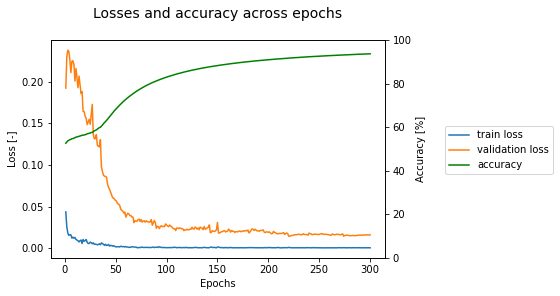

In [14]:
# https://matplotlib.org/stable/tutorials/introductory/usage.html

epoch = np.array(range(1,epochs+1))
epoch = epoch.astype(int)
running_loss_per_epoch_list = np.array(running_loss_per_epoch_list)
validation_loss_per_epoch_list = np.array(validation_loss_per_epoch_list)

fig, ax = plt.subplots()
ax.plot(epoch, running_loss_per_epoch_list, label = 'train loss')
ax.plot(epoch, validation_loss_per_epoch_list, label = 'validation loss')
ax.set_title('Losses and accuracy across epochs\n', fontsize=14)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss [-]')

ax2 = ax.twinx()
ax2.plot(epoch, accuracy, label = 'accuracy', color = 'g')
ax2.set_ylabel('Accuracy [%]')
ax2.set_ylim(0, 100)

fig.legend(bbox_to_anchor=(1.3,0.6))
plt.show()

## Saving the model

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Defining parameters for saving the model:

In [15]:
model_name = "resnet18_pretr_300epochs_data_augmentation_rot_L2_lr"
path_to_model = "../models/" + model_name + ".pth"

torch.save(net.state_dict(), path_to_model)
print("Model successfully saved!")

Model successfully saved!


## Predicting outputs

In [16]:
correct = 0
total = 0
label_list = []
prediction_list = []
probability = []

last_batch = 0

with torch.no_grad():
    
    for i, data in enumerate(testloader):   
        last_batch = i
        images, labels = data
        images, labels = images.to(device), labels.to(device) 
        outputs = net(images)
   
        probability, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        labels = labels.cpu()
        predicted = predicted.cpu()
        label_list += list(labels.numpy())
        prediction_list  += list(predicted.numpy())
            
print('Accuracy of the net model on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the net model on the test images: 99.43 %


## Confusion matrices

source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

In [17]:
cm = confusion_matrix(label_list, prediction_list)
tn, fp, fn, tp = confusion_matrix(label_list, prediction_list).ravel()
print(cm)
print(f"\n TN are: {tn} \n FP are: {fp} \n FN are: {fn} \n TP are: {tp}")

[[8775   38]
 [  62 8751]]

 TN are: 8775 
 FP are: 38 
 FN are: 62 
 TP are: 8751


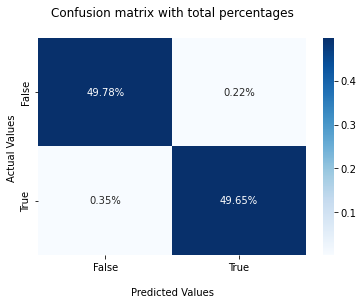

In [18]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues', fmt='.2%',)

ax.set_title('Confusion matrix with total percentages\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

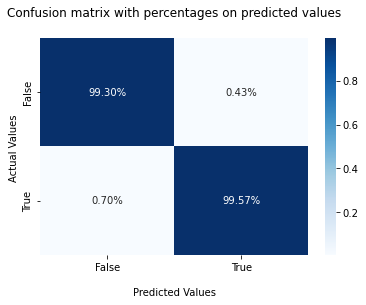

In [19]:
ax = sns.heatmap(cm/np.sum(cm, axis = 0), annot=True, cmap='Blues', fmt='.2%',)

ax.set_title('Confusion matrix with percentages on predicted values\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

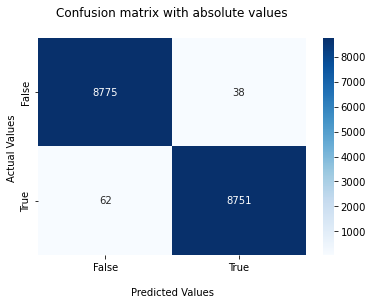

In [20]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',)

ax.set_title('Confusion matrix with absolute values\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [21]:
cm1 = [[ cm[0,0]/np.sum(cm, axis = 1)[0], cm[0,1]/np.sum(cm, axis = 1)[0]], [cm[1,0]/np.sum(cm, axis = 1)[1],cm[1,1]/np.sum(cm, axis = 1)[1]]]

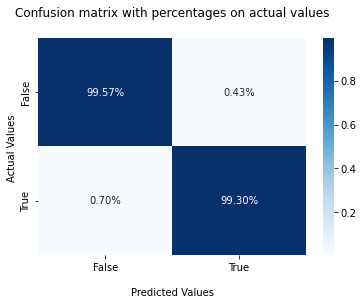

In [22]:
ax = sns.heatmap(cm1, annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Confusion matrix with percentages on actual values\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## Display metrics as precision, recall, F1-score

In [23]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1_score = 2/(1/recall + 1/precision)

print('The precision is:  %.2f %%\n' % (precision*100))
print('The recall is: %.2f %%\n' % (recall*100))
print(f'The F1_score is: %.2f %%\n' % (F1_score*100))

The precision is:  99.57 %

The recall is: 99.30 %

The F1_score is: 99.43 %



## Saving confusion matrix elements

In [24]:
csv_test_table = genfromtxt("../tables/test.csv", delimiter=',')
csv_test_table = csv_test_table.astype(int)

In [25]:
label_list = np.array(label_list)
prediction_list = np.array(prediction_list)
label_list = label_list.reshape(len(label_list),1)
prediction_list = prediction_list.reshape(len(prediction_list),1)
cm_label_prediction = np.concatenate((label_list, prediction_list), axis = 1)

In [26]:
cm_path = "../confusion_matrix_data_augmentation/"
data_path = "../data/test/"

for i in range(len(cm_label_prediction)):
    image_id = str(csv_test_table[i,0])
    
    if cm_label_prediction[i,0] == 1 and cm_label_prediction[i,1] == 0: #FN
        with Image.open(data_path + image_id + ".png") as im:
            im.save(cm_path + "FN/" + image_id + ".png")
            
    elif cm_label_prediction[i,0] == 1 and cm_label_prediction[i,1] == 1: #TP
        with Image.open(data_path + image_id + ".png") as im:
            im.save(cm_path + "TP/" + image_id + ".png")
            
    elif cm_label_prediction[i,0] == 0 and cm_label_prediction[i,1] == 0: #TN
        with Image.open(data_path + image_id + ".png") as im:
            im.save(cm_path + "TN/" + image_id + ".png")
        
    else: # cm_label_prediction[i,0] == 0 and cm_label_prediction[i,1] == 1 as FP
        with Image.open(data_path + image_id + ".png") as im:
            im.save(cm_path + "FP/" + image_id + ".png") 

In [27]:
print('End of notebook!')

End of notebook!
